# **Modules**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import datetime
import numpy as np
import pandas as pd

import copy
import math

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))

from typing import Literal, Tuple

from IPython.display import display, clear_output

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dbswfmhu because the default path (/home/fervent_babbage/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# **Config**

In [2]:
# !!! Run first data_generation.ipynb to generate these files from the main data csv stored in drive !!! 
train_path = './data/train_per_hour.csv'
val_path = './data/val_per_hour.csv'
test_path = './data/test_per_hour.csv'

In [3]:
# Fixed parameters
## Missing ratio for masked values
missing_ratio = 0.3
## Default value to replace the nan before being feeded to NN
val_spec = 0
## Each sample is a subsequence of length 48 (2days)
seq_length = 48
## Random seed
random_state = 42
torch.manual_seed(random_state)

In [4]:
# Common Hyperparameters for models
## Batch and epochs size
batch_size = 32
epochs = 50
## Dropout probability
dropout=0.5
## Learning rate
learning_rate = 0.001

In [5]:
# List of statistical methods covered
class_methods = ['mean','median','mode','LOCF','NOCB','linear_interpolation','spline_interpolation','knn','mice']

# **Data preprocessing**

In [6]:
def preprocess_data(train_path:str,val_path:str,test_path:str,scaler:callable)->Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    """
    Preprocess Data
    :param train_path: Path to train data
    :param val_path: Path to validation data
    :param test_path: Path to test data
    :param scaler: Scaler to use
    :return: Preprocessed train, validation and test data
    """
    # Read Data
    train = pd.read_csv(train_path)
    val = pd.read_csv(val_path)
    test = pd.read_csv(test_path)
    # Drop Date Column
    train.drop(['Date'],axis=1,inplace=True)
    val.drop(['Date'],axis=1,inplace=True)
    test.drop(['Date'],axis=1,inplace=True)    
    # Scale Data
    train = pd.DataFrame(scaler.fit_transform(train),columns=train.columns)
    val = pd.DataFrame(scaler.transform(val),columns=val.columns)
    test = pd.DataFrame(scaler.transform(test),columns=test.columns)
    return train, val, test

In [7]:
def generate_MCAR_nans(df:pd.DataFrame, missing_ratio:int,random_state:int)->Tuple[pd.DataFrame,np.ndarray]:
    """
    Generate Missing values in MCAR way
    :param df: Dataframe to be masked
    :param missing_ratio: Missing ratio per each feature
    :param random_state: Random state
    :return: Dataframe with missing values and mask
    """
    np.random.seed(random_state)
    df_nan = df.mask(np.random.random(df.shape) < missing_ratio,inplace=False)
    mask = np.isnan(df_nan.values).astype(int)
    return df_nan, mask

In [8]:
train, val, test = preprocess_data(train_path,val_path,test_path,MinMaxScaler()) 

In [9]:
test_nan, test_mask = generate_MCAR_nans(test, missing_ratio,random_state) # 1 for nan

# **Performance Evaluation Utils**

In [10]:
def evaluate_imputation_mse(df: pd.DataFrame, df_imputed: pd.DataFrame, mask: np.ndarray,method_title: str)->pd.DataFrame:
    """
    Evaluate the imputation performance by calculating the mean squared error (MSE) between the imputed and the original data.
    :param df: original data
    :param df_imputed: imputed data
    :param mask: mask of the missing values
    :param method_title: title of the imputation method
    :return: pd.DataFrame with the MSE
    """
    df = df * mask
    df_imputed = df_imputed * mask
    n = mask.sum()
    mse = 1/n * np.sum((df_imputed - df) ** 2).sum()
    result = pd.DataFrame({'method':method_title,'mse':mse},index = [0])
    return result

In [11]:
def t_test(df: pd.DataFrame,df_imputed: pd.DataFrame, mask: np.ndarray, method_title: str)->pd.DataFrame:
    """
    T-test for the imputed data and the original data
    :param df: original data
    :param df_imputed: imputed data
    :param mask: mask for the original data
    :param method_title: title of the imputation method
    :return: a dataframe with the p-value of the t-test for each column
    """
    df_imputed = df_imputed * mask + df_imputed *(1 - mask)
    ttest = stats.ttest_ind(df.values, df_imputed.values)
    test_stat = pd.DataFrame(columns=['method','column','p-value','same_distribution']) 
    for n in range(len(ttest.pvalue)): 
        test_stat.loc[n] = [method_title,df.columns[n], ttest.pvalue[n],ttest.pvalue[n]<0.05 ]                   
    return test_stat

In [12]:
def evaluate_set(list_methods: list,test: pd.DataFrame,test_nan: pd.DataFrame,test_mask: np.ndarray)->Tuple[pd.DataFrame,pd.DataFrame]:
    """
    Evaluate the imputation methods on the test set
    :param list_methods: list of imputation methods
    :param test: test set
    :param test_nan: test set with missing values
    :param test_mask: mask of missing values
    :return: a tuple of two dataframes, the first one contains the mse of each imputation method, the second one contains the t-test results
    """
    evals = pd.DataFrame()
    tests = pd.DataFrame()
    for strat in list_methods:
        df_imputed = classical_imputer(test_nan,strat)
        evals = pd.concat([evals,evaluate_imputation_mse(test,df_imputed,test_mask, strat)])
        tests = pd.concat([tests,t_test(test,df_imputed,test_mask,strat)])
    evals.sort_values(by=["mse"], inplace = True)
    evals.reset_index(drop=True, inplace=True)
    return evals,tests

# **Classical Imputation Methods**

In [13]:
def classical_imputer(test: pd.DataFrame,strategy: 
    Literal['mean','median','mode','LOCF','NOCB','linear_interpolation','spline_interpolation','knn','mice'],
    spline_order = 3,
    random_state = random_state,
    n_neighbors = 5)->pd.DataFrame:
    """
    Impute missing values using classical imputation methods
    :param test: Dataframe to impute
    :param strategy: Imputation strategy
    :param spline_order: Order of spline interpolation
    :param random_state: Random state for mice imputation
    :param n_neighbors: Number of neighbors for knn imputation
    :return: Imputed dataframe
    """
    try:
        df = test.copy()
        df_imputed = None
        if strategy == 'mean':
            mean_imp = SimpleImputer(strategy='mean')
            df_imputed = pd.DataFrame(mean_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'median':
            median_imp = SimpleImputer(strategy='median')
            df_imputed = pd.DataFrame(median_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'mode':
            most_frequent_imp = SimpleImputer(strategy='most_frequent')
            df_imputed =  pd.DataFrame(most_frequent_imp.fit_transform(df), columns=df.columns)
        elif strategy == 'LOCF':
            df_imputed = df.fillna(method='ffill').fillna(method='bfill')
        elif strategy == 'NOCB':
            df_imputed = df.fillna(method='bfill').fillna(method='ffill')
        elif strategy == 'linear_interpolation':
            df_imputed = df.interpolate(method='linear',limit_direction='both')
        elif strategy == 'spline_interpolation':
            df_imputed = df.interpolate(method='spline',order=spline_order,limit_direction='both')
        elif strategy == 'knn':
            knn_imp = KNNImputer(n_neighbors=n_neighbors)
            df_imputed = pd.DataFrame(knn_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'mice':
            mice_imp = IterativeImputer(random_state=random_state)
            df_imputed = pd.DataFrame(mice_imp.fit_transform(df),columns=df.columns)
        else:
            raise ValueError("Error : The strategy '{}' is not supported".format(strategy))
        return df_imputed
    except ValueError as e:
        raise(e)

# **DataSet and DataLoaders for DL models**

In [14]:
def random_mask_tensor(tensor:torch.Tensor, missing_ratio:float, seed:int, val_spec=val_spec)->Tuple[torch.Tensor,torch.Tensor]:
    """
    Randomly masks a tensor with a given missing ratio.
    :param tensor: the tensor to be masked
    :param missing_ratio: The ratio of values to be masked
    :return: the masked tensor and the mask tensor
    """
    # Calculate the number of values to mask
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    num_masked_values = int(tensor.numel() * missing_ratio)
    # Create a mask tensor with the same shape as the input tensor
    mask = torch.ones_like(tensor)
    # Randomly select values to be masked and set their corresponding mask tensor values to 0
    mask_indices = torch.randperm(tensor.numel())[:num_masked_values]
    mask = mask.flatten()
    mask[mask_indices] = 0
    mask = mask.reshape(tensor.shape)
    mask = 1 - mask 
    mask = mask.bool() 
    # Mask the input tensor
    masked_tensor = tensor.masked_fill(mask, val_spec)
    # Return the masked tensor and the mask tensor
    return masked_tensor, mask

In [15]:
class TSImputationTrainDataset(Dataset):
    """Time series imputation dataset for training"""
    def __init__(self, df, seq_length,missing_ratio):
        self.data = torch.tensor(df.values,dtype=torch.float32)
        self.seq_length = seq_length
        self.missing_ratio = missing_ratio 
            
    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        assert(len(self.data)>=self.seq_length)
        # Get a sequence of data of length seq_length
        target = self.data[index:index+self.seq_length]
        # generate masked input and the mask
        masked_input, mask = random_mask_tensor(target,self.missing_ratio,index)
        return target, masked_input, mask

In [16]:
class TSImputationEvalDataset(Dataset):
    """Time series imputation dataset for testing"""
    def __init__(self, df, df_nan, mask, seq_length, val_spec):
        self.seq_length = seq_length
        self.data = torch.tensor(df.values,dtype=torch.float32)
        self.data_nan = torch.tensor(df_nan.values,dtype=torch.float32)
        self.mask = torch.tensor(mask,dtype=torch.bool)
        self.val_spec = val_spec
        
    def __len__(self):
        return math.ceil(len(self.data)/self.seq_length)
        

    def __getitem__(self, index):
        # Get a sequence of data of length seq_length or less
        start = index*self.seq_length
        end = (index+1)*self.seq_length
        target = self.data[start:end]
        masked_input = self.data_nan[start:end]
        val_spec = self.val_spec

        mask = self.mask[start:end]
        if end > len(self.data) and start<len(self.data):
            padding = val_spec * torch.ones(self.seq_length - len(target), self.data.shape[1])
            target = torch.cat([target,padding], dim=0)
            masked_input = torch.cat([masked_input, padding], dim=0)
            mask = torch.cat([mask, torch.zeros(self.seq_length - len(target), self.data.shape[1]).bool()], dim=0)
        masked_input[torch.isnan(masked_input)] = val_spec
        return target, masked_input, mask

In [17]:
train_dataset = TSImputationTrainDataset(train,seq_length,missing_ratio)
val_dataset = TSImputationTrainDataset(val,seq_length,missing_ratio)
test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,seq_length,val_spec)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
print('total training batch number: {}'.format(len(train_loader)))
print('total validation batch number: {}'.format(len(val_loader)))
print('total test batch number: {}'.format(len(test_loader)))

total training batch number: 225
total validation batch number: 56
total test batch number: 82


# **DL models**

## **Utils**

In [20]:
class MaskedMSELoss(nn.Module):
    """ Masked MSE Loss
    """
    def __init__(self, reduction: str = 'mean'):
        super().__init__()
        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self,
                y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        """Compute the loss between a target value and a prediction.
        Args:
            y_pred: Estimated values
            y_true: Target values
            mask: boolean tensor with 0s at places where values should be ignored and 1s where they should be considered
        Returns
        -------
        if reduction == 'none':
            (num_active,) Loss for each active batch element as a tensor with gradient attached.
        if reduction == 'mean':
            scalar mean loss over batch as a tensor with gradient attached.
        """

        # for this particular loss, one may also elementwise multiply y_pred and y_true with the inverted mask
        masked_pred = torch.masked_select(y_pred, mask)
        masked_true = torch.masked_select(y_true, mask)

        return self.mse_loss(masked_pred, masked_true)

In [21]:
class HuberLossWithMask(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLossWithMask, self).__init__()
        self.delta = delta

    def forward(self, y_true, y_pred, mask):
        error = y_true - y_pred
        abs_error = torch.abs(error)
        quadratic = torch.clamp(abs_error, max=self.delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic ** 2 + self.delta * linear
        masked_loss = loss * mask.float()
        return masked_loss.mean()

In [22]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)]) 

In [23]:
def count_parameters(model):
    nb_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('This model has ',nb_params , ' parameter')
    return nb_params

In [24]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.eval()
    return model

In [25]:
# to test models that takes sequences as input (ex: AE_LSTM , AE_CONV)
def test_model_Seq(model,test_loader):
    test_predicted = []
    test_or = []

    for target, masked_input, mask in test_loader:
        if torch.cuda.is_available():
            target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
        output = model(masked_input)
        test_predicted.append(output)
        test_or.append(target)
        
    test_predicted = torch.cat(test_predicted, dim=0)
    test_predicted = torch.reshape(test_predicted,(test_predicted.shape[0]*test_predicted.shape[1],test_predicted.shape[2]))
    test_or = torch.cat(test_or, dim=0)
    test_or = torch.reshape(test_or,(test_or.shape[0]*test_or.shape[1],test_or.shape[2]))
    
    test_predicted = pd.DataFrame(test_predicted[:len(test)].cpu().detach().numpy(),columns=test.columns)
    test_or = pd.DataFrame(test_or[:len(test)].cpu().detach().numpy(),columns=test.columns)

    return test_or, test_predicted

In [26]:
# to test models that takes the flatten sequence as input (in our case only: MLP_AE)
def test_model_AE(model,test_loader):
    test_predicted = []
    test_or = []
    for target, masked_input, mask in test_loader:
        if torch.cuda.is_available():
            target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
        target = target.view(target.shape[0],target.shape[2]*target.shape[1])
        masked_input = masked_input.view(masked_input.shape[0],masked_input.shape[2]*masked_input.shape[1])
        output = model(masked_input)        
        test_predicted.append(output)
        test_or.append(target)
   
    test_predicted = torch.cat(test_predicted, dim=0)
    testing=test_predicted.view(test_predicted.shape[0]*seq_length,test.shape[1])
    test_or = torch.cat(test_or, dim=0)
    test_or=test_or.view(test_predicted.shape[0]*seq_length,test.shape[1])
    
    testing=pd.DataFrame(testing[:len(test)].cpu().detach().numpy(),columns=test.columns)
    test_or=pd.DataFrame(test_or[:len(test)].cpu().detach().numpy(),columns=test.columns)

    return test_or, testing

In [69]:
# to test transformer model
def test_model_TS(model,test_loader):
    test_predicted = []
    test_or = []

    for target, masked_input, mask in test_loader:
        if torch.cuda.is_available():
            target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
        output = model(masked_input,None)
        test_predicted.append(output)
        test_or.append(target)
        
    test_predicted = torch.cat(test_predicted, dim=0)
    test_predicted = torch.reshape(test_predicted,(test_predicted.shape[0]*test_predicted.shape[1],test_predicted.shape[2]))
    test_or = torch.cat(test_or, dim=0)
    test_or = torch.reshape(test_or,(test_or.shape[0]*test_or.shape[1],test_or.shape[2]))
    
    test_predicted=pd.DataFrame(test_predicted[:len(test)].cpu().detach().numpy(),columns=test.columns)
    test_or=pd.DataFrame(test_or[:len(test)].cpu().detach().numpy(),columns=test.columns)

    return test_or, test_predicted

## **MLP AutoEncoder**

In [27]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Decoder: affine function
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc4 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        # Encoder
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)

        # Decoder
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = torch.sigmoid(out)

        return out

### **Train the AutoEncoder**

In [28]:
# Parameters
## subsequence dimension 7*48
input_dim = train.shape[1] * seq_length
## output dimension
output_dim = input_dim

In [29]:
# Hyperparameters
## This is the parameter finetune for this model
reduction_parameter = 0.8
hidden_dim_1 = int(input_dim * reduction_parameter)
hidden_dim_2 = int(hidden_dim_1 * reduction_parameter)

In [30]:
# Init model and loss function
model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
if torch.cuda.is_available():
    model_ae = model_ae.cuda()
loss_fn = HuberLossWithMask()

In [31]:
def train_model_AE(model,loss_fn,epochs,train_loader,val_loader, learning_rate=0.001, gamma=0.9):
    """
    Train the autoencoder
    :param model:model of class FullyConnectedAutoencoder
    :param loss_fn: loss function
    :param eopchs: number of epochs
    :param train_loader: train loader
    :param val_loader: validation loader
    :param learning_rate: learning rate
    :param gamma: multiplicative factor of learning rate decay
    """
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    train_loss_list = []
    val_loss_list = []
    # train phase
    for epoch in range(epochs):
        # training phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            target = target.view(target.shape[0],target.shape[2]*target.shape[1])
            masked_input = masked_input.view(masked_input.shape[0],masked_input.shape[2]*masked_input.shape[1])
            mask = mask.view(mask.shape[0],mask.shape[2]*mask.shape[1])
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            optimizer.zero_grad()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        
        # validation phase  
        valid_loss = 0.0
        model.eval() 
        for batch in val_loader:
            x, x_nan, mask = batch
            x = x.view(x.shape[0],x.shape[2]*x.shape[1])
            x_nan = x_nan.view(x_nan.shape[0],x_nan.shape[2]*x_nan.shape[1])
            mask = mask.view(mask.shape[0],mask.shape[2]*mask.shape[1])
            if torch.cuda.is_available():
                x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
            outputs = model(x_nan)
            loss = loss_fn(outputs, x,mask)
            valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list,
     'hidden_dim_1':hidden_dim_1,
     'hidden_dim_2':hidden_dim_2
    }, PATH)
    clear_output()
    print('last model version path: ',PATH)
    return train_loss_list, val_loss_list

In [32]:
count_parameters(model_ae)

This model has  295886  parameter


295886

last model version path:  ./trained_models/AE_models/model_final_2023-03-05_08:34:52.351988


<Axes: xlabel='epochs'>

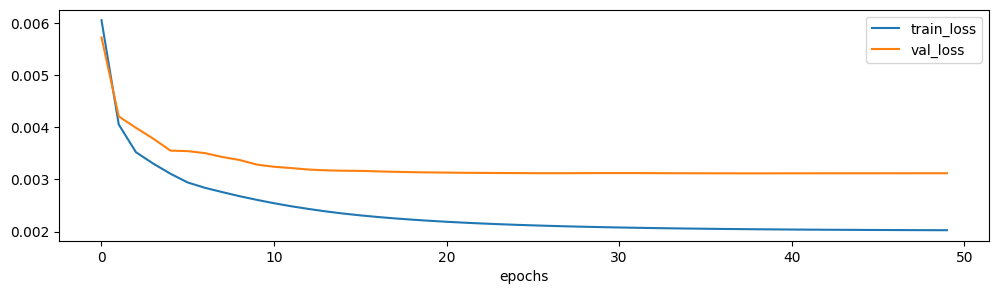

In [33]:
train_loss_list, val_loss_list = train_model_AE(model_ae,loss_fn,epochs,train_loader,val_loader, gamma=0.9)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

# **ConvAE**

In [34]:
class ConvAutoencoder(nn.Module):
    def __init__(self,T,D,hidden_dim1,hidden_dim2,in_channels=1,out_channels_1=16,out_channels_2=8):
        super(ConvAutoencoder, self).__init__()
        self.T = T
        self.D = D
        ## Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(out_channels_2 * T * D, hidden_dim1),
            nn.ReLU(True),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(True)
        )

        ## Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(True),
            nn.Linear(hidden_dim1, out_channels_2 * T * D),
            nn.ReLU(True),
            nn.Unflatten(dim=1,unflattened_size=(out_channels_2, T, D)),
            nn.ConvTranspose2d(in_channels=out_channels_2, out_channels=out_channels_1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels_1, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),
            nn.Sigmoid()
        )
    
        
    def forward(self, x):
        x = x.unsqueeze(1)  # add a channel dimension to the input (N, T, D) -> (N, 1, T, D)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.squeeze(1)  # remove the channel dimension from the output (N, 1, T, D) -> (N, T, D)
        return x

In [35]:
# Parameters
d_input = train.shape[1]
input_dim = train.shape[1] * seq_length

In [36]:
# Hyperparameters
reduction_parameter = 0.5
hidden_dim_1 = int(input_dim * reduction_parameter)
hidden_dim_2 = int(hidden_dim_1 * reduction_parameter)

In [37]:
#init model
model_conv_ae = ConvAutoencoder(seq_length,d_input,hidden_dim1 = hidden_dim_1, hidden_dim2 = hidden_dim_2)
if torch.cuda.is_available():
    model_conv_ae = model_conv_ae.cuda()
loss_fn = HuberLossWithMask()

In [38]:
def train_model_Conv_AE(model,loss_fn,epochs,train_loader,val_loader, learning_rate=learning_rate, gamma=0.9):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    train_loss_list = []
    val_loss_list = []
    for epoch in range(epochs):
        # train phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            optimizer.zero_grad()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        
        # validation phase
        valid_loss = 0.0
        model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                outputs = model(x_nan)
                loss = loss_fn(outputs, x,mask)
                valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/CONV_AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'hidden_dim_1':hidden_dim_1,
    'hidden_dim_2':hidden_dim_2,
    'missing_ratio': missing_ratio,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    print('last model version path: ',PATH)
    return train_loss_list, val_loss_list

In [39]:
count_parameters(model_conv_ae)

This model has  937133  parameter


937133

last model version path:  ./trained_models/CONV_AE_models/model_final_2023-03-05_08:40:26.840775


<Axes: xlabel='epochs'>

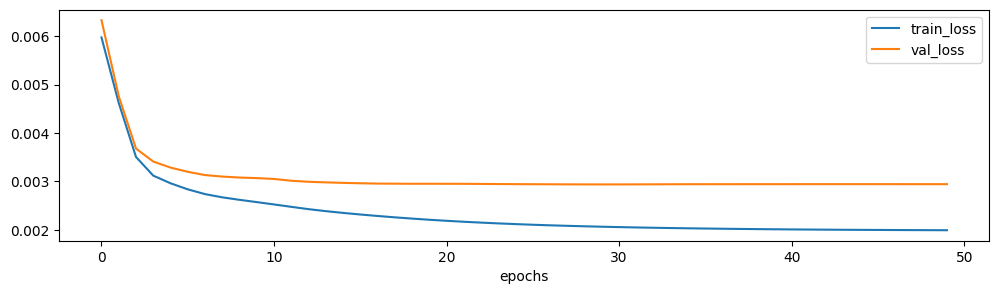

In [40]:
train_loss_list, val_loss_list = train_model_Conv_AE(model_conv_ae,loss_fn,epochs,train_loader,val_loader)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

## **LSTM AE**

In [41]:
class Encoder_LSTM(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        self.seq_len = seq_len
        self.no_features = no_features 
        self.embedding_size = embedding_size
        self.hidden_size = (2 * embedding_size)
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        x, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
class Decoder_LSTM(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, self.hidden_size))
        out = self.fc(x)
        return out
    
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim
        self.encoder = Encoder_LSTM(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder_LSTM(self.seq_len, self.embedding_dim, self.no_features)
    
    def forward(self, x):
        torch.manual_seed(0)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = torch.sigmoid(decoded)
        return decoded
    
    def encode(self, x):
        self.eval()
        encoded = self.encoder(x)
        return encoded
    
    def decode(self, x):
        self.eval()
        decoded = self.decoder(x)
        squeezed_decoded = decoded.squeeze()
        return squeezed_decoded

### **Train the LSTM AE**

In [42]:
# Parameters
d_input = train.shape[1]

In [43]:
#Hyperparameters
reduction_parameter = 0.7
embedding_size = int(d_input * reduction_parameter)

In [44]:
#init model and loss
model_ae_lstm = LSTM_AE(seq_length,d_input,embedding_size)
if torch.cuda.is_available():
    model_ae_lstm = model_ae_lstm.cuda()
loss_fn = HuberLossWithMask()

In [45]:
def train_model_AE_LSTM(model,loss_fn,epochs,train_loader,val_loader, learning_rate=learning_rate, gamma=0.9):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    train_loss_list = []
    val_loss_list = []
    for epoch in range(epochs):
        # train phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            optimizer.zero_grad()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        
        # validation phase
        valid_loss = 0.0
        model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                outputs = model(x_nan)
                loss = loss_fn(outputs, x,mask)
                valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/LSTM_AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'embedding_size':embedding_size,
    'missing_ratio': missing_ratio,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    print('last model version path: ',PATH)
    return train_loss_list, val_loss_list

In [46]:
count_parameters(model_ae_lstm)

This model has  719  parameter


719

last model version path:  ./trained_models/LSTM_AE_models/model_final_2023-03-05_08:49:13.203637


<Axes: xlabel='epochs'>

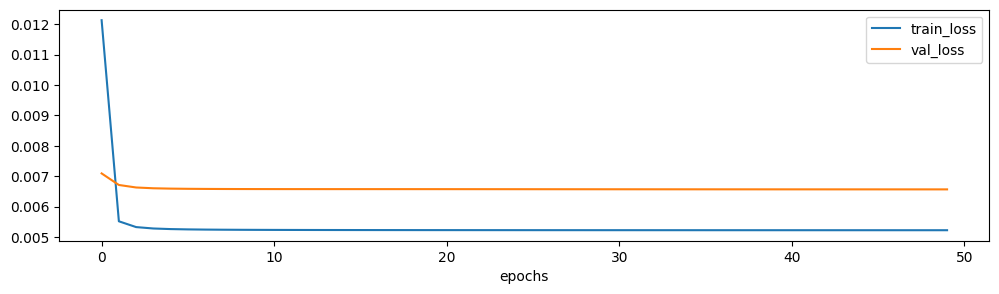

In [47]:
train_loss_list, val_loss_list = train_model_AE_LSTM(model_ae_lstm,loss_fn,epochs,train_loader,val_loader)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

## **Transformer Encoder Model**

In [48]:
class TST(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, Encoder,PositionalEncoding, N, d_model, d_input): ## layer = EncoderLayer
        super(TST, self).__init__()
        self.first_layer = nn.Linear(d_input, d_model)
        self.PE = PositionalEncoding
        self.Encoder = Encoder
        self.last_layer = nn.Linear(d_model, d_input)

    def forward(self, x, mask):
        "Pass the input through embedding and positional encoder and the output through a linear layer"
        x = self.first_layer(x)
        x = self.PE(x)
        x = self.Encoder(x,mask)
        x = self.last_layer(x)
        x = torch.sigmoid(x)
        return x

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N): 
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return x

class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0].forward(x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1].forward(x, self.feed_forward)

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )
        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))


class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [49]:
def make_model(d_input,N=6, d_model=128, d_ff=2048, h=8, dropout=0.5):
    "Helper: Construct a model from hyperparameters."
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    Encoder_model = Encoder(EncoderLayer(d_model, attn, ff, dropout), N)
    model = TST(Encoder_model,PositionalEncoding(d_model, dropout), N, d_model, d_input)
    # Initialize parameters with Xavier.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### **Train TE model**

In [50]:
# Parameters
d_input = train.shape[1]

In [56]:
# Hyperparameters
## dimension of the embedding
d_model = 128
## dimension of the output of FF layer
d_ff = 64
## Number of Encoders
N = 3
## Number of heads
h = 8

In [63]:
# main loop (train+eval)
def main_loop(TS_model, loss_fn, epochs, train_loader, val_loader, learning_rate=learning_rate, gamma=0.9):
    optimizer = torch.optim.Adam(TS_model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    
    train_loss_list = []
    val_loss_list = []
    min_valid_loss = np.inf
    for epoch in range(epochs):
        train_loss = 0
        # training
        TS_model.train() # mode "train" agit sur "dropout" ou "batchnorm"
        for batch in train_loader:
            x, x_nan, mask = batch
            if torch.cuda.is_available():
                x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
            optimizer.zero_grad()
            out = TS_model(x_nan,None)
            loss = loss_fn(out, x,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        # validation
        valid_loss = 0.0
        TS_model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                out = TS_model(x_nan,None)
                loss = loss_fn(out, x,mask)
                valid_loss += loss.item()
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            # Saving State Dict
            date_time = datetime.datetime.now()
            index = ('_').join(str(date_time).split(' '))
            PATH = './trained_models/model_' + index
            torch.save({
            'epoch': epoch,
            'd_input':d_input,
            'N': N,
            'd_model':d_model,
            'd_ff': d_ff,
            'h': h,
            'dropout':dropout,
            'batch_size': batch_size,
            'learning_rate':learning_rate,
            'missing_ratio': missing_ratio,
            'model_state_dict': TS_model.state_dict()
            }, PATH)
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/TS_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'd_input':d_input,
    'N': N,
    'd_model':d_model,
    'd_ff': d_ff,
    'h': h,
    'dropout':dropout,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'missing_ratio': missing_ratio,
    'model_state_dict': TS_model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    print('last model version path: ',PATH)
    return train_loss_list, val_loss_list

In [64]:
# Init Model
TS_model = make_model(d_input=d_input, N=N, d_model=d_model, d_ff=d_ff, h=h, dropout=dropout)
if torch.cuda.is_available():
    TS_model = TS_model.cuda()
# loss function
loss_fn = HuberLossWithMask()

In [65]:
count_parameters(TS_model)

This model has  251335  parameter


251335

last model version path:  ./trained_models/TS_models/model_final_2023-03-05_09:04:23.789252


<Axes: xlabel='epochs'>

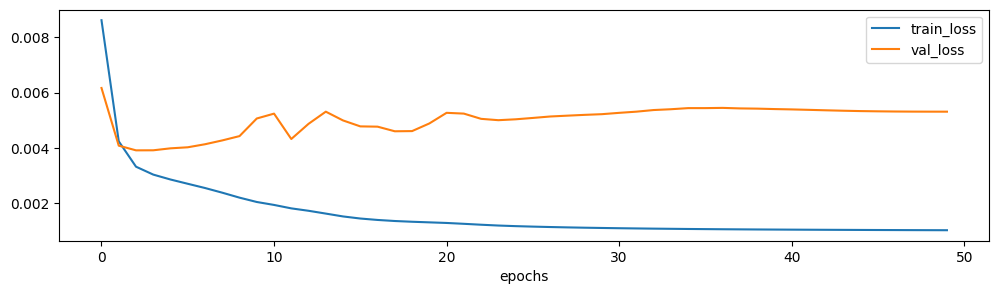

In [66]:
train_loss_list, val_loss_list = main_loop(TS_model,loss_fn,epochs,train_loader,val_loader)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

# **Synthesis**

In [77]:
# AE model evaluation
model_ae=load_model(model_ae,'./trained_models/AE_models/model_final_2023-03-05_08:34:52.351988') #get AE model
test_or, test_predicted = test_model_AE(model_ae,test_loader)
mse_ae = evaluate_imputation_mse(test_or, test_predicted, test_mask,"AE")
t_test_ae = t_test(test_or, test_predicted, test_mask, "AE")

# AE_conv model eval
model_conv_ae=load_model(model_conv_ae,'./trained_models/CONV_AE_models/model_final_2023-03-05_08:40:26.840775') #get Conv_AE model
test_or, test_predicted = test_model_Seq(model_conv_ae,test_loader)
mse_conv_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"Conv_autoencoder")
t_test_conv_ae = t_test(test_or, test_predicted, test_mask, "Conv_autoencoder")

# AE_LSTM model eval
model_ae_lstm=load_model(model_ae_lstm,'./trained_models/LSTM_AE_models/model_final_2023-03-05_08:49:13.203637') #get LSTM_AE model
test_or, test_predicted = test_model_Seq(model_ae_lstm,test_loader)
mse_lstm_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"LSTM_autoencoder")
t_test_lstm_ae = t_test(test_or, test_predicted, test_mask, "LSTM_autoencoder")

# transformer model eval
 # _____________ get transformer model _______________________
model_path = './trained_models/TS_models/model_final_2023-03-05_09:04:23.789252'
info = torch.load(model_path)
model_TS = make_model(d_input=info['d_input'], N=info['N'], d_model=info['d_model'], d_ff=info['d_ff'], h=info['h'], dropout=info['dropout'])
model_TS=load_model(model_TS,model_path) #get LSTM_AE model
if torch.cuda.is_available():
    model_TS = model_TS.cuda()
#_____________________________________________________________
test_or, test_predicted = test_model_TS(model_TS,test_loader)
mse_ts = evaluate_imputation_mse(test, test_predicted, test_mask,"Transformer_encoder")
t_test_ts  = t_test(test_or, test_predicted, test_mask, "Transformer_encoder")


In [78]:
evaluations, tests_classique = evaluate_set(class_methods,test,test_nan,test_mask)
evaluations=pd.concat([evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae],axis=0)
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

,method,mse
0,linear_interpolation,0.018206
1,Conv_autoencoder,0.018337
2,mice,0.019465
3,AE,0.020026
4,Transformer_encoder,0.031850
5,NOCB,0.031905
6,LOCF,0.032472
7,spline_interpolation,0.034908
8,mean,0.035487
9,knn,0.036358


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

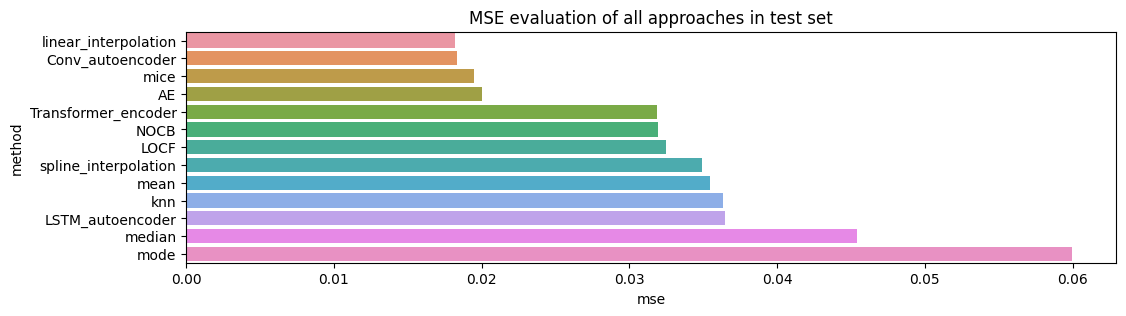

In [79]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')

In [80]:
tests_classique=pd.concat([tests_classique,t_test_ae,t_test_lstm_ae,t_test_ts,t_test_conv_ae],axis=0)
tests_classique

,method,column,p-value,same_distribution
0,mean,Global_active_power,0.889896,False
1,mean,Global_reactive_power,0.548351,False
2,mean,Voltage,0.947904,False
3,mean,Global_intensity,0.385762,False
4,mean,Sub_metering_1,0.618196,False
...,...,...,...,...
2,Conv_autoencoder,Voltage,0.208269,False
3,Conv_autoencoder,Global_intensity,0.020630,True
4,Conv_autoencoder,Sub_metering_1,0.000213,True
5,Conv_autoencoder,Sub_metering_2,0.076637,False


In [81]:
tests_classique["same_distribution"] = tests_classique["same_distribution"].astype(int)
tests_classique.drop(['column','p-value'],axis = 1,inplace=True)
tests_classique = tests_classique.groupby(['method'],as_index=False).sum()
tests_classique

,method,same_distribution
0,AE,6
1,Conv_autoencoder,5
2,LOCF,0
3,LSTM_autoencoder,5
4,NOCB,0
5,Transformer_encoder,7
6,knn,3
7,linear_interpolation,0
8,mean,0
9,median,6


In [82]:
tests_classique = tests_classique.sort_values(by=["same_distribution"],ascending=False)

Text(0.5, 1.0, 'total number of features with same distribution after imputation')

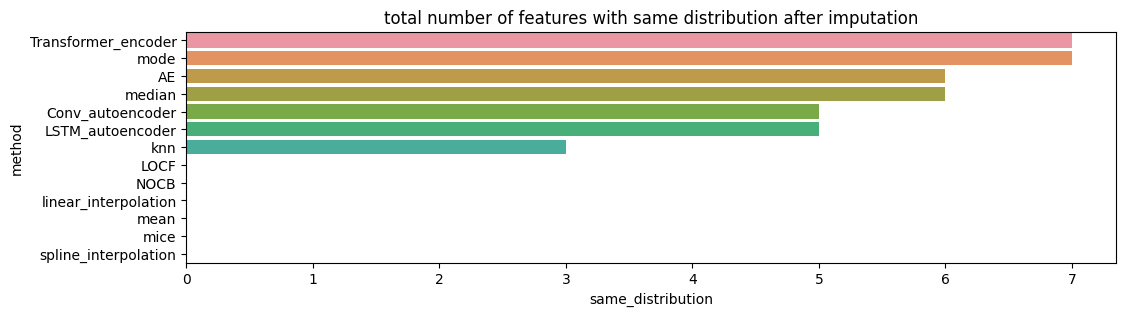

In [83]:
sns.barplot(x='same_distribution',y='method',data=tests_classique)
plt.title("total number of features with same distribution after imputation")